In [1]:
import sys
sys.path.append('../../')

In [4]:
import itertools
import os
import warnings

from matplotlib.gridspec import GridSpec

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas
from pandas import DataFrame

from soma.util.plot import plot_errors, lock_axes
from soma.util.errors import stat_errors_vs_sample_size
from soma.generators.eye import EyeGenerator
from soma.tests.som import som_test
from soma.tests.knn import knn_test
from soma.tests.c2st import c2s_nn_test, c2s_knn_test

plt.style.use('seaborn')
plt.style.use('seaborn-paper')
plt.style.use('tableau-colorblind10')
plt.rcParams.update({
    'figure.figsize': (4.77, 4.77),
    'text.usetex': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'lines.linewidth': 0.5,
    'errorbar.capsize': 1,
    'lines.markeredgewidth': 0.8
})

In [5]:
plot_dir = os.path.expanduser('~/Plots/by_dataset')
os.makedirs(plot_dir, exist_ok=True)

In [7]:
tests = {
    'knn': knn_test,
    'som': som_test,
    'c2st_knn': c2s_knn_test,
    'c2st_nn': c2s_nn_test,
}

In [8]:
counts_per_label = EyeGenerator.count_per_label()
counts_per_label

{'R': 4262, 'I': 3804, 'C': 2870}

In [9]:
generators = dict(
    C=EyeGenerator('C'),
    I=EyeGenerator('I'),
    R=EyeGenerator('R'),
)

Comparing with

*A Fast and Effective Large-Scale Two-Sample Test Based on Kernels*

# p-values
As table 6, 0 is better (rejects they are equal). We cross-check also comparing sets with unbalanced sample sizes.

In [6]:
pairwise = list(itertools.combinations(generators.keys(), 2))

In [7]:
results = DataFrame(columns=tests.keys(),
                    index=[f'{a} vs {b}' for a, b in pairwise] + [f'{a} vs {a}' for a in generators.keys()])
for a, b in pairwise:
    for test_name, test in tests.items():
        results.loc[f'{a} vs {b}'][test_name] = test(generators[a].array, generators[b].array)
for a in generators.keys():
    for test_name, test in tests.items():
        results.loc[f'{a} vs {a}'][test_name] = test(generators[a].sample(1000), generators[a].sample(2000))
results

,knn,som,c2st_knn,c2st_nn
C vs I,0.0,0.0,0.0,0.0
C vs R,0.0,0.0,0.0,0.0
I vs R,0.0,0.0,0.0002,0.024519
C vs C,0.71,0.115106,0.000001,0.421786
I vs I,0.17,0.742949,0.0,0.0
R vs R,0.62,0.291653,0.000004,0.0


# Power of the test
As table 8, higher is better

In [10]:
sample_sizes = np.array([100, 200, 250, 300, 400, 500, 2500, 5000, 10000])
significance = 0.001
repeat = int(2 * (1 / significance))
repeat

2000

## I vs C

In [11]:
#ic_results = stat_errors_vs_sample_size(generators['I'], generators['C'], tests, sample_sizes, alpha=significance, repeat=repeat)
#ic_results.to_csv(os.path.join(plot_dir, 'ic_results.csv'))
ic_results = pandas.read_csv('../../results/sample_size/ic_results.csv', index_col=[0, 1])

In [12]:
ic_results['power'] = 1 - ic_results['error2']
ic_results

error1  error2      time   power
test     samples                                  
knn      100      0.0065  0.0270  0.004112  0.9730
         200      0.0085  0.0000  0.006147  1.0000
         250      0.0125  0.0000  0.010050  1.0000
         300      0.0110  0.0000  0.008149  1.0000
         400      0.0095  0.0000  0.011076  1.0000
         500      0.0100  0.0000  0.021772  1.0000
         2500     0.0070  0.0000  0.112353  1.0000
         5000     0.0085  0.0000  0.298800  1.0000
         10000    0.0125  0.0000  0.574973  1.0000
som      100      0.0000  0.9575  0.022704  0.0425
         200      0.0000  0.0530  0.027098  0.9470
         250      0.0000  0.0060  0.047455  0.9940
         300      0.0000  0.0000  0.036946  1.0000
         400      0.0010  0.0000  0.045958  1.0000
         500      0.0000  0.0000  0.070940  1.0000
         2500     0.0005  0.0000  0.321815  1.0000
         5000     0.0010  0.0000  0.663638  1.0000
         10000    0.0000  0.0000  1.328999  1.0000
c2st_knn 100      0.0010  0.8360  0.004290  0.1640
         200      0.0030  0.4350  0.003851  0.5650
         250      0.0010  0.2355  0.006355  0.7645
         300      0.0005  0.1370  0.004595  0.8630
         400      0.0010  0.0315  0.006874  0.9685
         500      0.0005  0.0045  0.008762  0.9955
         2500     0.0010  0.0000  0.114023  1.0000
         5000     0.0015  0.0000  0.395949  1.0000
         10000    0.0010  0.0000  1.435206  1.0000
c2st_nn  100      0.0005  0.9210  0.191920  0.0790
         200      0.0025  0.6510  0.238266  0.3490
         250      0.0010  0.4125  0.344513  0.5875
         300      0.0020  0.3555  0.225247  0.6445
         400      0.0010  0.1175  0.260082  0.8825
         500      0.0000  0.0485  0.276503  0.9515
         2500     0.0010  0.0000  0.893767  1.0000
         5000     0.0000  0.0000  1.581483  1.0000
         10000    0.0000  0.0000  4.114443  1.0000

## I vs R

In [13]:
#ir_results = stat_errors_vs_sample_size(generators['I'], generators['R'], tests, sample_sizes, alpha=significance, repeat=repeat)
#ir_results.to_csv('../../results/sample_size/ir_results.csv')
ir_results = pandas.read_csv('../../results/sample_size/ir_results.csv', index_col=[0, 1])

## R vs C

In [14]:
#rc_results = stat_errors_vs_sample_size(generators['R'], generators['C'], tests, sample_sizes, alpha=significance, repeat=repeat)
#rc_results.to_csv(os.path.join(plot_dir, 'rc_results.csv'))
rc_results = pandas.read_csv('../../results/sample_size/rc_results.csv', index_col=[0, 1])

In [15]:
rc_results['power'] = 1 - rc_results['error2']
rc_results

error1  error2      time   power
test     samples                                  
knn      100      0.0075  0.1545  0.002952  0.8455
         200      0.0095  0.0040  0.004884  0.9960
         250      0.0090  0.0000  0.006434  1.0000
         300      0.0075  0.0000  0.007739  1.0000
         400      0.0085  0.0000  0.012024  1.0000
         500      0.0115  0.0000  0.014093  1.0000
         2500     0.0065  0.0000  0.114801  1.0000
         5000     0.0085  0.0000  0.299806  1.0000
         10000    0.0130  0.0000  2.282994  1.0000
som      100      0.0000  0.9930  0.013802  0.0070
         200      0.0000  0.3275  0.023331  0.6725
         250      0.0000  0.0760  0.028960  0.9240
         300      0.0000  0.0125  0.034391  0.9875
         400      0.0005  0.0000  0.050828  1.0000
         500      0.0000  0.0000  0.055242  1.0000
         2500     0.0010  0.0000  0.317472  1.0000
         5000     0.0000  0.0000  0.649534  1.0000
         10000    0.0005  0.0000  2.700976  1.0000
c2st_knn 100      0.0005  0.9380  0.002264  0.0620
         200      0.0030  0.7020  0.003236  0.2980
         250      0.0010  0.5355  0.004094  0.4645
         300      0.0020  0.4415  0.005496  0.5585
         400      0.0015  0.1890  0.007293  0.8110
         500      0.0000  0.0685  0.007896  0.9315
         2500     0.0000  0.0000  0.110204  1.0000
         5000     0.0010  0.0000  0.391197  1.0000
         10000    0.0025  0.0000  2.780619  1.0000
c2st_nn  100      0.0010  0.9770  0.123378  0.0230
         200      0.0005  0.8605  0.207527  0.1395
         250      0.0005  0.7565  0.217077  0.2435
         300      0.0000  0.6855  0.217263  0.3145
         400      0.0005  0.4400  0.257103  0.5600
         500      0.0005  0.2740  0.256368  0.7260
         2500     0.0005  0.0000  0.805451  1.0000
         5000     0.0000  0.0010  1.877913  0.9990
         10000    0.0000  0.0000  5.441658  1.0000

# Plot

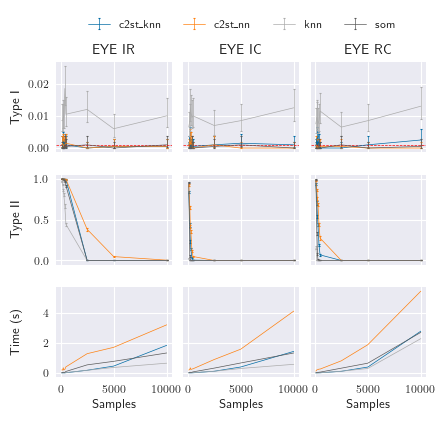

In [16]:
gs = GridSpec(nrows=4, ncols=3, height_ratios=[0.1] + [0.3] * 3, hspace=0.3, wspace=0.1)

fig = plt.figure()

# IR
axes_ir = [fig.add_subplot(gs[1 + i, 0]) for i in range(3)]
_ = plot_errors(ir_results, show_time=True, legend=False, fig=fig, axes=axes_ir, alpha=significance, n=repeat)
axes_ir[0].set_title('EYE IR')

# IC
axes_ic = [fig.add_subplot(gs[1 + i, 1]) for i in range(3)]
_ = plot_errors(ic_results, show_time=True, legend=False, fig=fig, axes=axes_ic, alpha=significance, n=repeat)
axes_ic[0].set_title('EYE IC')

# RC
axes_rc = [fig.add_subplot(gs[1 + i, 2]) for i in range(3)]
_ = plot_errors(rc_results, show_time=True, legend=False, fig=fig, axes=axes_rc, alpha=significance, n=repeat)
axes_rc[0].set_title('EYE RC')

# Legend
ax_legend = fig.add_subplot(gs[0, :])
ax_legend.legend(handles=axes_ir[0].get_legend_handles_labels()[0], loc='center', ncol=4)
ax_legend.set_axis_off()

for ax in itertools.chain(axes_ic, axes_rc):
    ax.set_ylabel(None)
    ax.set_yticklabels([])

for i in range(3):
    lock_axes(axes_ir[i], axes_ic[i], axes_rc[i])

fig.savefig(os.path.join(plot_dir, 'eye.pdf'))

## I vs I

Obviously this must report a low power, since it should **not** be able to reject $H_0$ (both distributions are the same!).
This is a cross-check to verify the code is working as intended.

In [ ]:
ii_results = stat_errors_vs_sample_size(generators['I'], generators['I'], tests, sample_sizes, alpha=significance,
                                        repeat=10)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
ii_results